In [1]:
#This is a convolutional AutoEncoder

In [46]:
import os

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mplimg

import PIL
from PIL import Image

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, LSTM, Flatten, Reshape, TimeDistributed
from keras.models import Model
from keras import backend as K

# Preprocessing
These cells are for importing and manipulating frames for training

## Video \#0
### Raquel practicing

In [3]:
#Constant Settings
datapath = 'VideoData/Video0/frames'
image_names = [_ for _ in os.listdir(datapath) if '.j' in _ or '.p' in _]

currentVideo = 0
imageDim = 252

trainTestSplit = 0.85 #Ratio of input domain belonging to train

In [4]:
#Image Getters
def getVideoFrame(v, x, ext='png'):
    datapath, filename = 'VideoData/Video{}/frames'.format(v), 'frame{:05}.{}'.format(x, ext)
    return os.path.join(datapath, filename)

def getImagePath(x):
    return os.path.join(datapath, image_names[x])

<class 'PIL.PngImagePlugin.PngImageFile'>


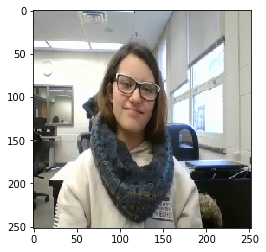

In [5]:
#Test for image getter
testimg = Image.open(getVideoFrame(0, 70))
print(type(testimg))
testimg = testimg.resize((imageDim, imageDim))
plt.imshow(testimg)

In [29]:
images = 152 #152 frames, all used
video0 = np.array([np.array(Image.open(getVideoFrame(0, _+1)).resize((imageDim, imageDim)))/255 for _ in range(images)])

In [7]:
ratioSplit = int(allData.shape[0] * trainTestSplit)

x_train, x_test = allData[:ratioSplit], allData[ratioSplit:]

## Video \#1
### Some Random Person On Youtube

<class 'PIL.JpegImagePlugin.JpegImageFile'>


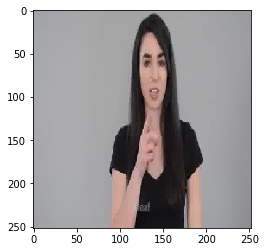

In [7]:
#Test for image getter
testimg = Image.open(getVideoFrame(1, 202, 'jpg'))
print(type(testimg))
testimg = testimg.resize((imageDim, imageDim))
plt.imshow(testimg)

In [31]:
currentVideo = 1
images = 1390 #3832 frames total
video1 = np.array([np.array(Image.open(getVideoFrame(currentVideo, _+1, 'jpg')).resize((imageDim, imageDim)))/255 for _ in range(images)])

## Video \#2
### Some (Other) Random Person On Youtube

<class 'PIL.JpegImagePlugin.JpegImageFile'>


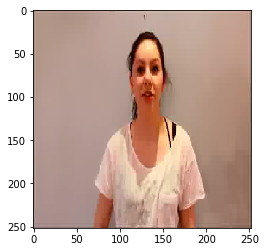

In [30]:
#Test for image getter
testimg = Image.open(getVideoFrame(2, 202, 'jpg'))
print(type(testimg))
testimg = testimg.resize((imageDim, imageDim))
plt.imshow(testimg)

In [32]:
currentVideo = 2
images = 930 #2331 frames in total
video2 = np.array([np.array(Image.open(getVideoFrame(currentVideo, _+1, 'jpg')).resize((imageDim, imageDim)))/255 for _ in range(images)])

# Model Design - Auto-Encoder
These cells are for creating and testing auto-encoder designs 

In [8]:
#Big AutoEncoder
input_img = Input(shape=(imageDim, imageDim, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
# (32, 32, 8) = 8192

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [9]:
#Small AutoEncoder
input_img = Input(shape=(imageDim, imageDim, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (8, 8, 8) i.e. 512-dimens"ional
# (64, 64, 8) = 32678

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [10]:
### Auto-Encoder Data Preparation ###
# This uses the same data as the LSTM, but it is treated in a different fasion
# Each image is its own data point, so all of the videos' frames are concated into one large array
# and then split for training and testing
#X = np.concatenate([video0, video1, video2])
X = np.concatenate([video0, video1])
ratioSplit = int(X.shape[0] * trainTestSplit)

x_train, x_test = X[:ratioSplit], X[ratioSplit:]

In [12]:
#If you're computer is screeching to a halt at this point (as mine is/was), run this cell... It should help a bit :)
del video0
del video1

In [17]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adagrad', loss='binary_crossentropy')

In [18]:
h = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=1,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 3386 samples, validate on 598 samples
Epoch 1/50
3386/3386 [==============================] - 16s 5ms/step - loss: 0.5465 - val_loss: 0.4336
Epoch 2/50
3386/3386 [==============================] - 16s 5ms/step - loss: 0.5456 - val_loss: 0.4336
Epoch 3/50
3386/3386 [==============================] - 16s 5ms/step - loss: 0.5456 - val_loss: 0.4335
Epoch 4/50
3386/3386 [==============================] - 16s 5ms/step - loss: 0.5456 - val_loss: 0.4335
Epoch 5/50
3386/3386 [==============================] - 15s 5ms/step - loss: 0.5455 - val_loss: 0.4334
Epoch 6/50
3386/3386 [==============================] - 15s 5ms/step - loss: 0.5455 - val_loss: 0.4334
Epoch 7/50
3386/3386 [==============================] - 15s 5ms/step - loss: 0.5455 - val_loss: 0.4333
Epoch 8/50
3386/3386 [==============================] - 15s 4ms/step - loss: 0.5455 - val_loss: 0.4333
Epoch 9/50
3386/3386 [==============================] - 15s 4ms/step - loss: 0.5455 - val_loss: 0.4333
Epoch 10/50
3386/3386 [===

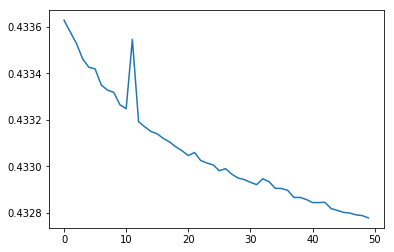

In [19]:
plt.plot(h.history['val_loss'])

In [21]:
plt.savefig('AE-adagrad-50epochs-1batch.png')
autoencoder.save('signlanguage-autoencoder.model')
autoencoder.save_weights('signlanguage-autoencoder.weights')

<Figure size 432x288 with 0 Axes>

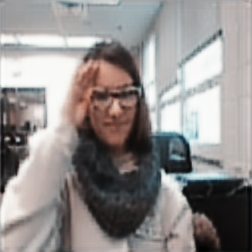

In [23]:
testoutput = autoencoder.predict(X[30:31]) * 255
Image.fromarray(testoutput[0].astype('uint8'), 'RGB')

In [50]:
deepae = Input(shape=(imageDim, imageDim, 3))
deepae = autoencoder.layers[1](deepae)
deepae = autoencoder.layers[2](deepae)

deepae = Conv2D(8, (3, 3), activation='relu', padding='same')(deepae)
deepae = MaxPooling2D((2, 2), padding='same')(deepae)

deepae = Conv2D(16, (3, 3), activation='relu', padding='same')(deepae)

deepae_encoded = autoencoder.layers[3](deepae)

deepae = autoencoder.layers[4](deepae_encoded)
deepae = autoencoder.layers[5](deepae)
deepae = autoencoder.layers[6](deepae)
deepae = autoencoder.layers[7](deepae)

deepae = Conv2D(8, (3, 3), activation='relu')(deepae)
deepae = UpSampling2D((2, 2))(deepae)

deepae_decoded = autoencoder.layers[8](deepae)

In [ ]:
autoencoderX = Model(input_img, deepae_decoded)
autoencoderX.compile(optimizer='adamax', loss='binary_crossentropy')

In [56]:
encoded.get_shape()

TensorShape([Dimension(None), Dimension(63), Dimension(63), Dimension(16)])

In [97]:
#Classifier
encoderCoreShape = 63*63*8
look_back = 20
classifierX = Reshape((63*63,16))(encoded)
classifierX = LSTM(16, input_shape=(encoderCoreShape, look_back), return_sequences=True)(classifierX)
classifierX = LSTM(8, input_shape=(encoderCoreShape, look_back), return_sequences=True)(classifierX)
#classifierX = Dense(16, activation='relu')(classifierX)
classifierX = TimeDistributed(Dense(2, activation='softmax'))(classifierX)

In [25]:
#Auto Encoder training is done
del X

In [89]:
#Data prep
#TODO - All samples must be the same size (20 frames)

#video0
hello0_0 = video0[16:36]
name0_0 = video0[90:110]

#video1
    #hello1_0 = video1[68:129] #61
hello1_1 = video1[128:148]
name1_0 = video1[1039:1059]
    #name1_1 = video1[1084:1124] #40
name1_2 = video1[1130:1150]
name1_3 = video1[1209:1229]
    #name1_4 = video1[1240:1297] #57 test
name1_5 = video1[1363:1383] #test


#video2
hello2_0 = video2[204:224]
hello2_1 = video2[247:267] #test
name2_0 = video2[660:680]
name2_1 = video2[688:708]
name2_2 = video2[872:892] #test

x_train_LSTM = np.stack((hello0_0, hello2_0, name0_0, name1_0, name1_2, name1_3, name2_0, name2_1), axis = 0)
#y_train_LSTM = np.concatenate((np.array([[1, 0] for i in range(hello0_0.shape[0] + hello2_0.shape[0])]), np.array([[0, 1] for i in range(name0_0.shape[0] + name1_0.shape[0] + name1_1.shape[0] + name1_2.shape[0] + name1_3.shape[0] + name2_0.shape[0] + name2_1.shape[0])])), axis = 0)
y_train_LSTM = np.array([[1,0] for i in range(8*63*63)]).reshape(8, 63*63, 2)

x_test_LSTM = np.concatenate((hello1_1, hello2_1, name1_5, name2_2), axis = 0)
#y_test_LSTM = np.concatenate((np.array([[1, 0] for i in range(hello1_1.shape[0] + hello2_1.shape[0])]), np.array([[0, 1] for i in range(name1_5.shape[0] + name2_2.shape[0])])), axis = 0)
y_test_LSTM = np.array([[1,0] for i in range(x_test_LSTM.shape[0])]).reshape(4, 20, 2)

In [92]:
x_train_LSTM.shape

(8, 20, 252, 252, 3)

In [98]:
simpleClassifier = Model(Input(shape=(20, imageDim, imageDim, 3)), classifierX)
simpleClassifier.compile(optimizer='adamax', loss='categorical_crossentropy') #'binary_crossentropy'

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_1:0", shape=(?, 252, 252, 3), dtype=float32) at layer "input_1". The following previous layers were accessed without issue: []

In [90]:
classifierHistory = simpleClassifier.fit(x_train_LSTM, y_train_LSTM,
                epochs=5,
                batch_size=20,
                shuffle=False)
#                validation_data=(x_test_LSTM, y_test_LSTM))

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (8, 20, 252, 252, 3)

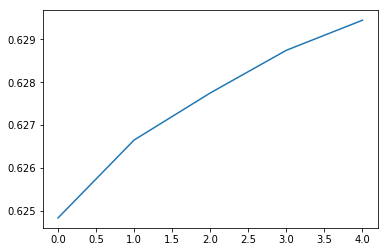

In [42]:
plt.plot(classifierHistory.history['val_loss'])

In [79]:
simpleClassifier.save('LSTM_classifierX')

In [43]:
name_prediction = simpleClassifier.predict(video1[1207:1232])
np.mean(name_prediction, axis=0)

array([0.38460281, 0.61539716], dtype=float32)

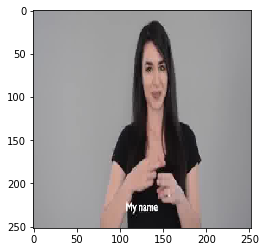

In [93]:
plt.imshow(video1[1050])

In [44]:
hi_prediction = simpleClassifier.predict(video1[128:148])
np.mean(hi_prediction, axis=0)

array([0.38532537, 0.61467457], dtype=float32)